In [82]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [83]:
df = pd.read_csv('/content/MadaLine.csv',names=['x', 'y','label'],header=None)
df

,x,y,label
0,-0.642823,0.720606,0.0
1,-0.218126,0.677263,0.0
2,-0.582930,-0.347496,0.0
3,0.285127,0.091750,0.0
4,-0.335577,-0.313893,0.0
...,...,...,...
195,0.744066,-1.206548,1.0
196,-0.457547,1.286227,1.0
197,-1.020000,-0.783926,1.0
198,1.363429,-0.800250,1.0


In [84]:
df = df.sample(frac = 1)
df

,x,y,label
58,-0.307634,0.380198,0.0
63,-0.144555,0.126067,0.0
35,0.032285,-0.272660,0.0
19,0.750276,-0.334067,0.0
59,-0.913047,-0.084945,0.0
...,...,...,...
40,-0.633524,-0.266629,0.0
0,-0.642823,0.720606,0.0
73,-0.470053,-0.785619,0.0
8,0.189896,0.891588,0.0


In [85]:
data = df[['x','y']]
inputs = data.to_numpy()
inputs.shape[0]

200

In [86]:
# Convert to Bipolar
label = df[['label']]
target = label.to_numpy()
target[np.isclose(target, 0)] = -1

In [87]:
df0 = df.loc[df['label']  == 0 ]
df1 = df.loc[df['label']  == 1]

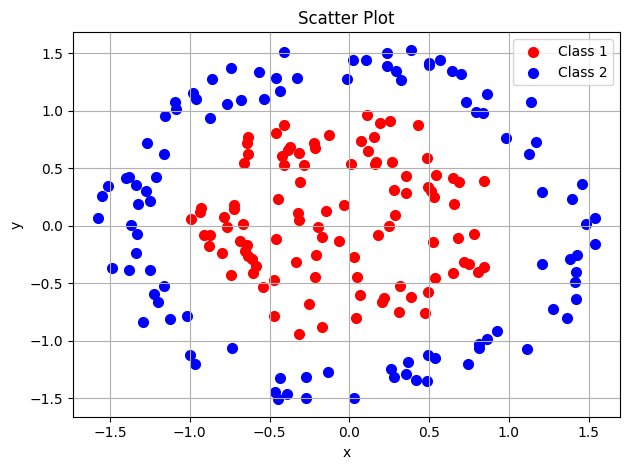

In [88]:
# scatter plot
plt.scatter(df0['x'], df0['y'], c="red", linewidths=2)
plt.scatter(df1['x'], df1['y'], c="blue", linewidths=2)
# add axis labels and legend
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Class 1", "Class 2"])
# add grid
plt.grid(True)
# add title
plt.title("Scatter Plot")
# adjust subplot spacing
plt.tight_layout()
# show the plot
plt.show()

In [89]:
df = df.sample(frac=1, random_state=5).reset_index()
df

,index,x,y,label
0,146,-1.271710,0.720439,1.0
1,64,0.688995,0.383063,0.0
2,157,1.540464,0.062636,1.0
3,188,-0.677537,1.091894,1.0
4,137,-1.213164,0.423174,1.0
...,...,...,...,...
195,67,-0.219877,0.720819,0.0
196,184,-1.275058,0.302450,1.0
197,175,-1.384006,-0.386906,1.0
198,54,-0.932415,0.155296,0.0


MADaline Rule I Implementation

In [90]:
def find_decision_boundary(start_x, end_x, weights, biases):
    """
    Calculates the decision boundary given the start and end x values, weights, and biases.

    Args:
    start_x (float): The start x value.
    end_x (float): The end x value.
    weights (numpy.ndarray): An array of weights.
    biases (float): The bias value.

    Returns:
    inputs (numpy.ndarray): An array of x values.
    output (numpy.ndarray): An array of y values representing the decision boundary.
    """

    # Create an array of x values
    inputs = np.linspace(start_x, end_x)

    # Calculate the corresponding y values using the given weights and biases
    output = -(weights[0] * inputs + biases)
    output = output / weights[1]

    return inputs, output


def initialize_weights(sm, num_neurons_layer1, num_neurons_layer2):
    # Set a random seed for reproducibility
    np.random.seed(10)

    # Generate random weights and biases for the first layer
    weights = np.random.rand(num_neurons_layer1, num_neurons_layer2) * sm
    biases = np.zeros((num_neurons_layer1, 1))

    # Initialize weights and biases for the second layer
    # The weights for the second layer are initialized to 1
    weights_layer2 = np.array([[1]*num_neurons_layer1])
    biases_layer2 = num_neurons_layer1 - 1

    # Return all the initialized weights and biases
    return weights, biases, weights_layer2, biases_layer2

def apply_activation_function(net):
    # np.where(condition, x, y) returns an array with the same shape as condition,
    # where the elements are taken from x where condition is True,
    # and from y elsewhere. In this case, the condition is whether each element of
    # the input net is greater than or equal to 0. If it is, the corresponding element
    # in the output h is set to 1; otherwise, it is set to -1.
    h = np.where(net >= 0, 1, -1)
    return h

def forward_propagation(weights, inputs, biases, should_reshape):
    # Check if inputs should be reshaped
    if should_reshape:
        inputs = inputs.reshape((2, 1))
    # Calculate the net input
    net_input = np.dot(weights, inputs) + biases
    # Apply activation function to net input to obtain outputs
    outputs = apply_activation_function(net_input)
    # Return both net input and outputs
    return net_input, outputs

def update_weights(weights, biases, inputs, target, net_input, output, learning_rate, num_neurons_layer1):
    # Reshape inputs and net_input
    inputs = inputs.reshape((1, 2))
    net_input = net_input.reshape((num_neurons_layer1, 1))

    # If target is equal to output, no weight or bias update is necessary
    if target == output:
        return weights, biases
    # If target is 1 and output is -1, update weights and biases for the neuron with the highest net input
    elif target == 1 and target != output:    #output=-1 but target=1
        argmax_neuron = np.argmax(net_input)
        diff_bias = learning_rate * (1 - net_input[argmax_neuron])
        diff_weight = learning_rate * np.dot((1 - net_input[argmax_neuron]), inputs)
        biases[argmax_neuron] = biases[argmax_neuron] + diff_bias
        weights[argmax_neuron] = weights[argmax_neuron] + diff_weight
    # If target is -1 and output is 1, update weights and biases for all neurons with positive net input
    elif target == -1 and target != output:   # output=1 but target=-1
        positive_indices = np.argwhere(net_input > 0)
        diff_bias = learning_rate * (-1 - net_input)
        diff_weight = learning_rate * np.dot((-1 - net_input), inputs)
        new_biases = biases + diff_bias
        new_weights = weights + diff_weight
        for i in positive_indices[:, 0]:
            weights[i] = new_weights[i]
            biases[i] = new_biases[i]
    # Return updated weights and biases
    return weights, biases

# Define a function named calculate_error
def calculate_error(target, output):
    # Calculate the error using the mean squared error formula
    error = 0.5 * np.power((target - output), 2)
    # Return the calculated error
    return error

def predict(inputs, target, weights, biases, num_neurons_layer1):
    # initialize an empty list to store predicted outputs
    predicted_output = []

    # initialize biases_layer2 as a numpy array of zeros
    biases_layer2 = np.zeros((num_neurons_layer1, 1))

    # initialize weights_layer2 as a numpy array of shape (1, num_neurons_layer1) with all elements as 1
    weights_layer2 = np.array([[1]*num_neurons_layer1])

    # update biases_layer2 to have a value of num_neurons_layer1 - 1
    biases_layer2 = num_neurons_layer1 - 1

    # loop through each input and calculate the predicted output using forward propagation
    for i in range(inputs.shape[0]):
        # call the forward_propagation function with inputs, weights, biases, and should_reshape=True
        net_input, outputs = forward_propagation(weights, inputs[i], biases, should_reshape=True)

        # call the forward_propagation function with weights_layer2, outputs, biases_layer2, and should_reshape=False
        net_input2, output = forward_propagation(weights_layer2, outputs, biases_layer2, should_reshape=False)

        # append the predicted output to the predicted_output list
        predicted_output.append(output[0])

    # return the list of predicted outputs
    return predicted_output

In [91]:
def MRI(df0, df1, inputs, target, num_neurons_layer1=3, num_neurons_layer2=2, learning_rate=0.0001, max_iter=200, samples=None, plot=True):
    # If samples is not provided, set it to the number of rows in the input data.
    if samples is None:
        samples = inputs.shape[0]
    # Print the number of samples.
    print('sample:', samples)
    # Initialize variables
    sm = 0.001
    error_list = []
    errors = []
    mean_error = 10**3
    weights, biases, weights_layer2, biases_layer2 = initialize_weights(sm, num_neurons_layer1, num_neurons_layer2)  # Step 0
    # Iterate through the training process
    for i in range(max_iter):
        # Perform forward propagation
        net_input, outputs = forward_propagation(weights, inputs[i % samples], biases, should_reshape=True)  # Step 4 and 5
        net_input2, output = forward_propagation(weights_layer2, outputs, biases_layer2, should_reshape=False)  # Step 6
        # Calculate the error of the output
        error = calculate_error(target[i % samples], output)
        errors.append(error)
        # If an epoch has ended, calculate the mean error of the epoch and append it to the error list
        if i % samples == 0 and i != 0:
            mean_error = np.mean(errors)
            error_list.append(mean_error)
            errors = []
            # Print the epoch number and the mean error of the epoch
            print('Epoch %d / %d' % (len(error_list), int(max_iter / samples)))
            print('loss:', mean_error)
            for j in range(len(weights)):
                # Print the weights and biases for each layer
                print('W%d:'%(j+1),weights[j])
                print('b%d:'%(j+1),biases[j])
        # If the mean error is 0 or the difference between the mean error of the last two epochs is 0, an early stop occurred
        if mean_error == 0 or (i > 50 and len(error_list) >= 2 and error_list[-1] - error_list[-2] == 0):
            print('An early stop occurred!')
            # If plot is True, plot the error, decision boundary, confusion matrix, and classification report
            if plot:
                plt.plot(error_list)
                plt.xlabel('Epochs')
                plt.ylabel('Mean Squared Error')
                plt.title('Error Plot')
                plt.grid(True)
                plt.show()
                df0 = df0
                df1 = df1
                plt.scatter(df0['x'], df0['y'], c ="red", linewidths = 0.1)
                plt.scatter(df1['x'], df1['y'], c ="blue", linewidths = .1)
                # Plot the decision boundary
                for i in range(num_neurons_layer1):
                    px1, px2 = find_decision_boundary(-2, 2, weights[i], biases[i])
                    plt.plot(px1, px2)

                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend(["Class 1" , "Class 2"])
                plt.xlim([-2, 2])
                plt.ylim([-2, 2])
                plt.show()
                # Generate predictions
                predicted_output = predict(inputs, target, weights, biases, num_neurons_layer1)
                # Create confusion matrix
                cm = confusion_matrix(target, predicted_output)
                # Plot heatmap of confusion matrix
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
                plt.xlabel("Predicted labels")
                plt.ylabel("True labels")
                plt.title("Confusion Matrix")
                plt.tight_layout()
                plt.show()
                predicted_output = predict(inputs, target,weights,biases,num_neurons_layer1)
                print(classification_report(target, predicted_output))
            return weights, biases, error_list
        weights, b = update_weights(weights, biases, inputs[i % samples], target[i % samples], net_input, output, learning_rate, num_neurons_layer1)  # Step 7

    if plot:
        plt.plot(error_list)
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error')
        plt.title('Error Plot')
        plt.grid(True)
        plt.show()
        df0 = df0
        df1 = df1
        plt.scatter(df0['x'], df0['y'], c ="red", linewidths = 0.1)
        plt.scatter(df1['x'], df1['y'], c ="blue", linewidths = .1)

        for i in range(num_neurons_layer1):
            px1, px2 = find_decision_boundary(-2, 2, weights[i], biases[i])
            plt.plot(px1, px2)

        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(["Class 1" , "Class 2"])
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.show()
        # Generate predictions
        predicted_output = predict(inputs, target, weights, biases, num_neurons_layer1)
        # Create confusion matrix
        cm = confusion_matrix(target, predicted_output)
        # Plot heatmap of confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()
        predicted_output = predict(inputs, target,weights,biases,num_neurons_layer1)
        print(classification_report(target, predicted_output))

    return weights, biases, error_list

In [92]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def find_decision_boundary(start_x, end_x, weights, biases):
    inputs = np.linspace(start_x, end_x)
    output = -(weights[0] * inputs + biases)
    output = output / weights[1]
    return inputs, output

def initialize_weights(sm, num_neurons_layer1, num_neurons_layer2):
    np.random.seed(10)
    weights = np.random.rand(num_neurons_layer1, num_neurons_layer2) * sm
    biases = np.zeros((num_neurons_layer1, 1))
    weights_layer2 = np.array([[1]*num_neurons_layer1])
    biases_layer2 = num_neurons_layer1 - 1
    return weights, biases, weights_layer2, biases_layer2

def apply_activation_function(net):
    h = np.where(net >= 0, 1, -1)
    return h

def forward_propagation(weights, inputs, biases, should_reshape):
    if should_reshape:
        inputs = inputs.reshape((2, 1))
    net_input = np.dot(weights, inputs) + biases
    outputs = apply_activation_function(net_input)
    return net_input, outputs

def update_weights(weights, biases, inputs, target, net_input, output, learning_rate, num_neurons_layer1):
    inputs = inputs.reshape((1, 2))
    net_input = net_input.reshape((num_neurons_layer1, 1))
    if target == output:
        return weights, biases
    elif target == 1 and target != output:    #output=-1 but target=1
        argmax_neuron = np.argmax(net_input)
        diff_bias = learning_rate * (1 - net_input[argmax_neuron])
        diff_weight = learning_rate * np.dot((1 - net_input[argmax_neuron]), inputs)
        biases[argmax_neuron] = biases[argmax_neuron] + diff_bias
        weights[argmax_neuron] = weights[argmax_neuron] + diff_weight
    elif target == -1 and target != output:   # output=1 but target=-1
        positive_indices = np.argwhere(net_input > 0)
        diff_bias = learning_rate * (-1 - net_input)
        diff_weight = learning_rate * np.dot((-1 - net_input), inputs)
        new_biases = biases + diff_bias
        new_weights = weights + diff_weight
        for i in positive_indices[:, 0]:
            weights[i] = new_weights[i]
            biases[i] = new_biases[i]
    return weights, biases

def calculate_error(target, output):
    error = 0.5 * np.power((target - output), 2)
    return error

def predict(inputs, target, weights, biases, num_neurons_layer1):
    predicted_output = []
    biases_layer2 = np.zeros((num_neurons_layer1, 1))
    weights_layer2 = np.array([[1]*num_neurons_layer1])
    biases_layer2 = num_neurons_layer1 - 1
    for i in range(inputs.shape[0]):
        net_input, outputs = forward_propagation(weights, inputs[i], biases, should_reshape=True)
        net_input2, output = forward_propagation(weights_layer2, outputs, biases_layer2, should_reshape=False)
        predicted_output.append(output[0])
    return predicted_output


def MRI(df0, df1, inputs, target, num_neurons_layer1=3, num_neurons_layer2=2, learning_rate=0.0001, max_iter=200, samples=None, plot=True):
    if samples is None:
        samples = inputs.shape[0]
    print('sample:', samples)
    sm = 0.001
    error_list = []
    errors = []
    mean_error = 10**3
    weights, biases, weights_layer2, biases_layer2 = initialize_weights(sm, num_neurons_layer1, num_neurons_layer2)  # Step 0
    for i in range(max_iter):
        net_input, outputs = forward_propagation(weights, inputs[i % samples], biases, should_reshape=True)  # Step 4 and 5
        net_input2, output = forward_propagation(weights_layer2, outputs, biases_layer2, should_reshape=False)  # Step 6
        error = calculate_error(target[i % samples], output)
        errors.append(error)
        if i % samples == 0 and i != 0:
            mean_error = np.mean(errors)
            error_list.append(mean_error)
            errors = []
            print('Epoch %d / %d' % (len(error_list), int(max_iter / samples)))
            print('loss:', mean_error)
            for j in range(len(weights)):
                print('W%d:'%(j+1),weights[j])
                print('b%d:'%(j+1),biases[j])
        if mean_error == 0 or (i > 50 and len(error_list) >= 2 and error_list[-1] - error_list[-2] == 0):
            print('An early stop occurred!')
            if plot:
                plt.plot(error_list)
                plt.xlabel('Epochs')
                plt.ylabel('Mean Squared Error')
                plt.title('Error Plot')
                plt.grid(True)
                plt.show()
                df0 = df0
                df1 = df1
                plt.scatter(df0['x'], df0['y'], c ="red", linewidths = 0.1)
                plt.scatter(df1['x'], df1['y'], c ="blue", linewidths = .1)

                for i in range(num_neurons_layer1):
                    px1, px2 = find_decision_boundary(-2, 2, weights[i], biases[i])
                    plt.plot(px1, px2)

                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend(["Class 1" , "Class 2"])
                plt.xlim([-2, 2])
                plt.ylim([-2, 2])
                plt.show()
                # Generate predictions
                predicted_output = predict(inputs, target, weights, biases, num_neurons_layer1)
                # Create confusion matrix
                cm = confusion_matrix(target, predicted_output)
                # Plot heatmap of confusion matrix
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
                plt.xlabel("Predicted labels")
                plt.ylabel("True labels")
                plt.title("Confusion Matrix")
                plt.tight_layout()
                plt.show()
                predicted_output = predict(inputs, target,weights,biases,num_neurons_layer1)
                print(classification_report(target, predicted_output))
            return weights, biases, error_list
        weights, b = update_weights(weights, biases, inputs[i % samples], target[i % samples], net_input, output, learning_rate, num_neurons_layer1)  # Step 7

    if plot:
        plt.plot(error_list)
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error')
        plt.title('Error Plot')
        plt.grid(True)
        plt.show()
        df0 = df0
        df1 = df1
        plt.scatter(df0['x'], df0['y'], c ="red", linewidths = 0.1)
        plt.scatter(df1['x'], df1['y'], c ="blue", linewidths = .1)

        for i in range(num_neurons_layer1):
            px1, px2 = find_decision_boundary(-2, 2, weights[i], biases[i])
            plt.plot(px1, px2)

        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(["Class 1" , "Class 2"])
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.show()
        # Generate predictions
        predicted_output = predict(inputs, target, weights, biases, num_neurons_layer1)
        # Create confusion matrix
        cm = confusion_matrix(target, predicted_output)
        # Plot heatmap of confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()
        predicted_output = predict(inputs, target,weights,biases,num_neurons_layer1)
        print(classification_report(target, predicted_output))

    return weights, biases, error_list

### Madaline Results (3 neurons)

sample: 200
Epoch 1 / 10
loss: 0.6865671641791045
W1: [ 0.00052088 -0.00024867]
b1: [-0.0005001]
W2: [6.67430181e-06 5.87552604e-04]
b2: [-0.00070009]
W3: [-0.00025209 -0.00017522]
b3: [-0.00040001]
Epoch 2 / 10
loss: 0.36
W1: [ 0.00069627 -0.00027503]
b1: [-0.0003001]
W2: [-0.00024133  0.000624  ]
b2: [-0.00070009]
W3: [-0.00050754 -0.0001669 ]
b3: [-0.00039999]
Epoch 3 / 10
loss: 0.27
W1: [ 0.0007423  -0.00019951]
b1: [-0.00030013]
W2: [-8.57285293e-05  6.79132851e-04]
b2: [-0.00070008]
W3: [-0.00053536 -0.00018317]
b3: [-0.0005]
Epoch 4 / 10
loss: 0.31
W1: [ 6.28196303e-04 -4.47456952e-05]
b1: [-0.00050018]
W2: [-0.00026004  0.00065395]
b2: [-0.00070008]
W3: [-0.00041546 -0.00046297]
b3: [-0.00059999]
Epoch 5 / 10
loss: 0.34
W1: [7.02296281e-04 8.96107561e-05]
b1: [-0.00050017]
W2: [-0.00042207  0.00062194]
b2: [-0.00070009]
W3: [-0.00037374 -0.00049164]
b3: [-0.00059993]
Epoch 6 / 10
loss: 0.31
W1: [0.00072269 0.0001305 ]
b1: [-0.00050018]
W2: [-0.00043232  0.00053502]
b2: [-0.0008

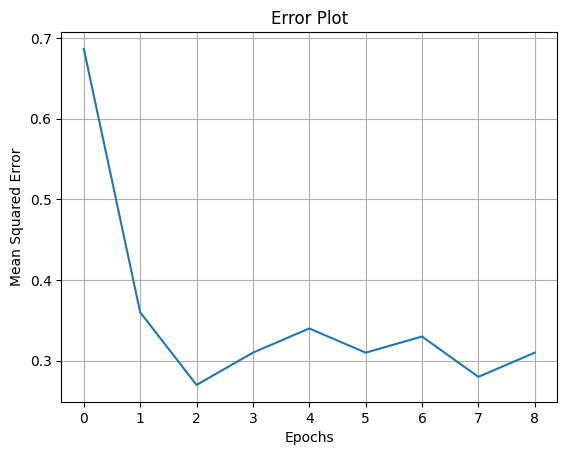

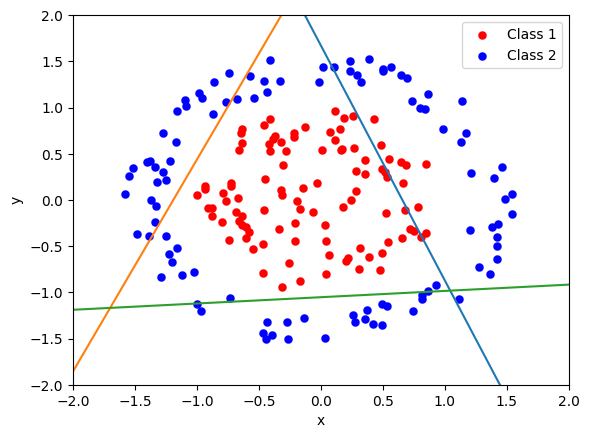

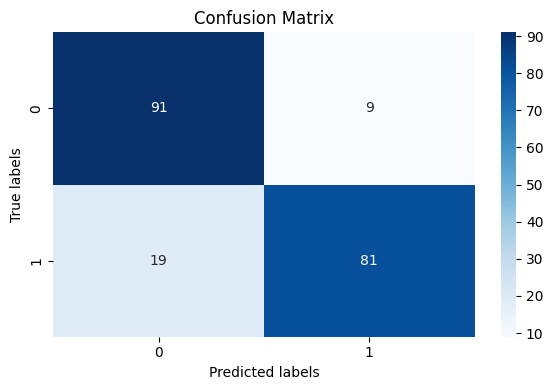

              precision    recall  f1-score   support

        -1.0       0.83      0.91      0.87       100
         1.0       0.90      0.81      0.85       100

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [93]:
weights, biases, error_list = MRI(df0, df1, inputs,target,num_neurons_layer1 = 3 ,num_neurons_layer2 = 2,max_iter = 2000,learning_rate = 0.0001,samples = inputs.shape[0])

sample: 200
Epoch 1 / 10
loss: 0.5373134328358209
W1: [-0.00237915  0.02957133]
b1: [-0.03023864]
W2: [ 0.03110265 -0.01973628]
b2: [-0.02026408]
W3: [-0.02683456 -0.0054485 ]
b3: [-0.03030039]
Epoch 2 / 10
loss: 0.39
W1: [0.01182877 0.03887428]
b1: [-0.04034242]
W2: [ 0.03977044 -0.02082015]
b2: [-0.03064831]
W3: [-0.04802359  0.00308353]
b3: [-0.04033568]
Epoch 3 / 10
loss: 0.34
W1: [-0.01368093  0.03935151]
b1: [-0.05042569]
W2: [ 0.04982589 -0.02732341]
b2: [-0.03111983]
W3: [-0.03821154 -0.02458053]
b3: [-0.05038669]
Epoch 4 / 10
loss: 0.25
W1: [-0.01341004  0.0570569 ]
b1: [-0.05041631]
W2: [ 0.0433422  -0.02712718]
b2: [-0.04106859]
W3: [-0.05109418 -0.01756444]
b3: [-0.05024493]
Epoch 5 / 10
loss: 0.32
W1: [-0.00899195  0.0519667 ]
b1: [-0.06044729]
W2: [ 0.04920583 -0.03708041]
b2: [-0.04075999]
W3: [-0.04669638 -0.03429726]
b3: [-0.06028066]
Epoch 6 / 10
loss: 0.27
W1: [-0.01390133  0.05745495]
b1: [-0.06049422]
W2: [ 0.07264779 -0.0176545 ]
b2: [-0.03044016]
W3: [-0.06545356

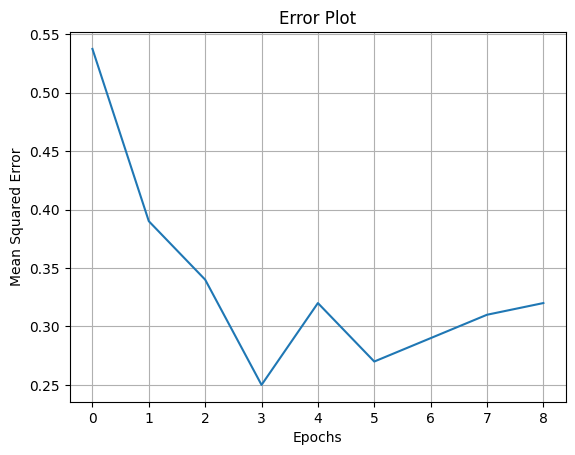

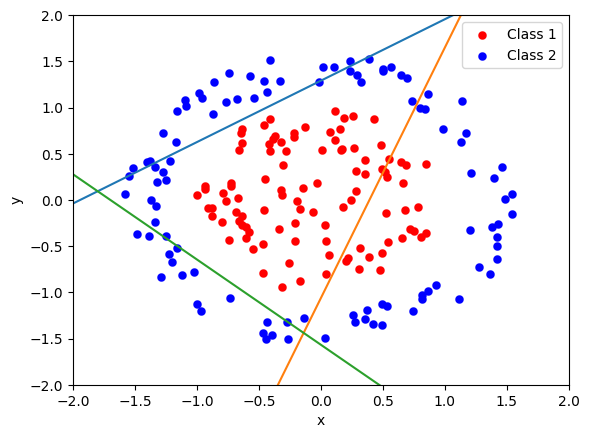

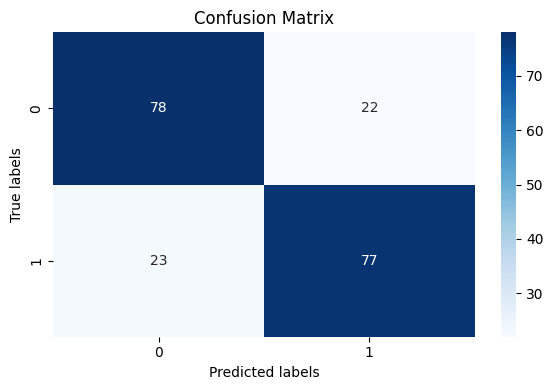

              precision    recall  f1-score   support

        -1.0       0.77      0.78      0.78       100
         1.0       0.78      0.77      0.77       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



In [94]:
weights, biases, error_list = MRI(df0, df1, inputs,target,num_neurons_layer1 = 3 ,num_neurons_layer2 = 2,max_iter = 2000,learning_rate = 0.01,samples = inputs.shape[0])

### Madaline Results (4 neurons)

sample: 200
Epoch 1 / 10
loss: 0.6069651741293532
W1: [ 0.00049989 -0.00026919]
b1: [-0.00040004]
W2: [0.00038073 0.00049315]
b2: [-0.0007001]
W3: [0.00022771 0.00014288]
b3: [-0.00040007]
W4: [-2.52539544e-04 -2.36817463e-05]
b4: [-0.00029991]
Epoch 2 / 10
loss: 0.39
W1: [ 0.00043497 -0.0004322 ]
b1: [-0.00040005]
W2: [0.00017107 0.00060531]
b2: [-0.00070004]
W3: [0.00022771 0.00014288]
b3: [-0.00040007]
W4: [-3.74965204e-04 -7.92733174e-05]
b4: [-0.00039991]
Epoch 3 / 10
loss: 0.27
W1: [ 0.00020675 -0.0005594 ]
b1: [-0.00050005]
W2: [-4.19870572e-05  6.73510006e-04]
b2: [-0.00070004]
W3: [3.24391908e-04 7.86289079e-05]
b3: [-0.00040006]
W4: [-0.00050412 -0.00013687]
b4: [-0.00039992]
Epoch 4 / 10
loss: 0.15
W1: [ 0.00027804 -0.00059472]
b1: [-0.00050006]
W2: [-0.00025288  0.00067207]
b2: [-0.00070005]
W3: [0.00035364 0.00013296]
b3: [-0.00040006]
W4: [-0.00044072 -0.00010381]
b4: [-0.00049994]
Epoch 5 / 10
loss: 0.05
W1: [ 0.00024694 -0.00051971]
b1: [-0.00060006]
W2: [-0.00025288  0

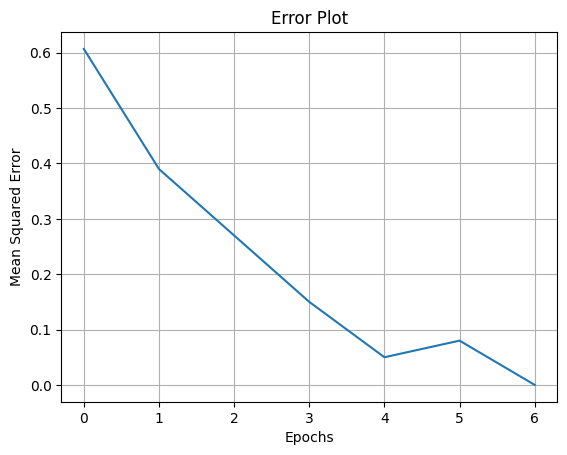

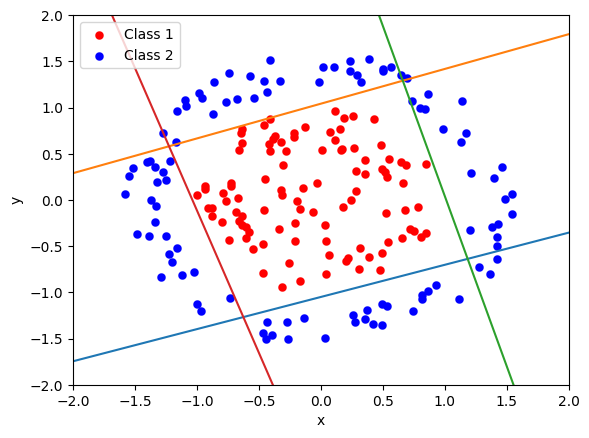

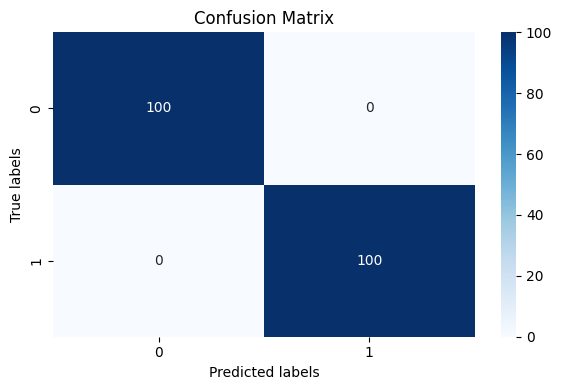

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [95]:
weights, biases, error_list = MRI(df0, df1, inputs,target,num_neurons_layer1 = 4 ,num_neurons_layer2 = 2,max_iter = 2000,learning_rate = 0.0001,samples = inputs.shape[0])

sample: 200
Epoch 1 / 10
loss: 0.6567164179104478
W1: [3.88575441e-04 1.29391940e-05]
b1: [-0.00099965]
W2: [ 0.00124233 -0.00061151]
b2: [-0.00100069]
W3: [-2.20745076e-03 -1.99684311e-05]
b3: [-0.00150218]
W4: [0.00010379 0.00123188]
b4: [-0.00200077]
Epoch 2 / 10
loss: 0.26
W1: [0.00117329 0.00039669]
b1: [-0.00100007]
W2: [ 0.00044909 -0.00154935]
b2: [-0.00150076]
W3: [-0.00193225 -0.00025812]
b3: [-0.00200235]
W4: [-0.00012913  0.00200807]
b4: [-0.0020009]
Epoch 3 / 10
loss: 0.18
W1: [0.00141045 0.00031192]
b1: [-0.00150004]
W2: [ 0.00067292 -0.0019038 ]
b2: [-0.00150101]
W3: [-2.15770793e-03 -7.88448583e-05]
b3: [-0.00200241]
W4: [8.64776637e-05 1.81035495e-03]
b4: [-0.00250141]
Epoch 4 / 10
loss: 0.19
W1: [0.00138496 0.00088635]
b1: [-0.00150013]
W2: [ 0.00065416 -0.00183042]
b2: [-0.002001]
W3: [-0.00261557  0.00011879]
b3: [-0.00200269]
W4: [-7.74430795e-05  2.17507343e-03]
b4: [-0.00250125]
Epoch 5 / 10
loss: 0.13
W1: [0.00166063 0.00081023]
b1: [-0.00149989]
W2: [ 0.0006924

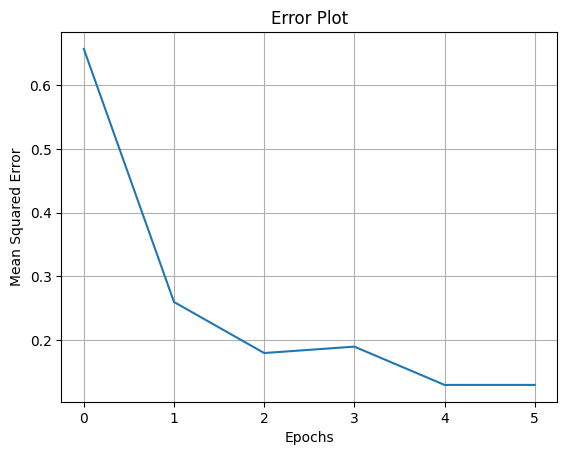

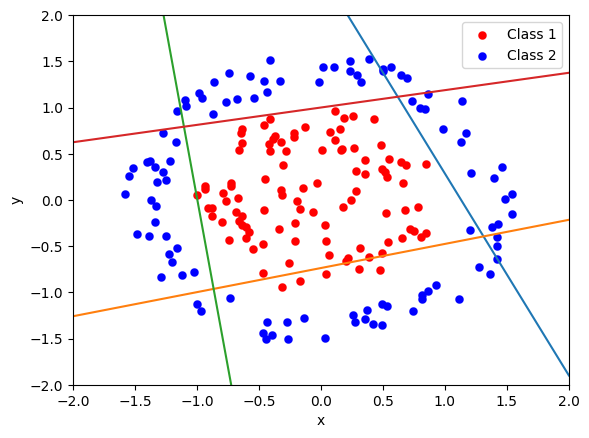

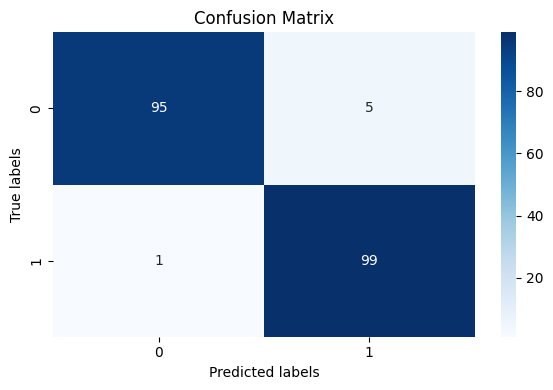

              precision    recall  f1-score   support

        -1.0       0.99      0.95      0.97       100
         1.0       0.95      0.99      0.97       100

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [96]:
weights, biases, error_list = MRI(df0, df1, inputs,target,num_neurons_layer1 = 4 ,num_neurons_layer2 = 2,max_iter = 2000,learning_rate = 0.0005,samples = inputs.shape[0])

### Madaline Results (8 neurons)

sample: 200
Epoch 1 / 10
loss: 0.4975124378109453
W1: [-0.00515579  0.01961052]
b1: [-0.01994853]
W2: [ 0.00476099 -0.00168691]
b2: [-0.02007305]
W3: [-0.00352379  0.00033627]
b3: [-0.02036621]
W4: [ 0.0232132  -0.00152538]
b4: [-2.18096394e-06]
W5: [-2.84872318e-02 -8.82187728e-05]
b5: [-0.03032984]
W6: [ 8.85110012e-05 -2.28113755e-02]
b6: [-0.02003788]
W7: [ 0.00209342 -0.01248963]
b7: [-0.03025563]
W8: [-0.00099912  0.01389345]
b8: [-0.03003651]
Epoch 2 / 10
loss: 0.27
W1: [0.00370657 0.02918547]
b1: [-0.03006594]
W2: [ 0.00476099 -0.00168691]
b2: [-0.02007305]
W3: [-0.00352379  0.00033627]
b3: [-0.02036621]
W4: [ 0.02782239 -0.00023395]
b4: [-0.0301413]
W5: [-0.0411908  -0.00497618]
b5: [-0.03032005]
W6: [ 0.00379514 -0.02603264]
b6: [-0.03001173]
W7: [ 0.00209342 -0.01248963]
b7: [-0.03025563]
W8: [-0.00099912  0.01389345]
b8: [-0.03003651]
Epoch 3 / 10
loss: 0.18
W1: [0.00592518 0.04222103]
b1: [-0.04035358]
W2: [ 0.00476099 -0.00168691]
b2: [-0.02007305]
W3: [-0.00352379  0.000

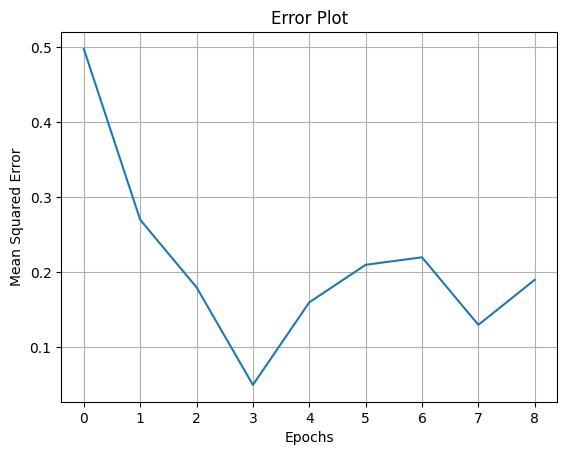

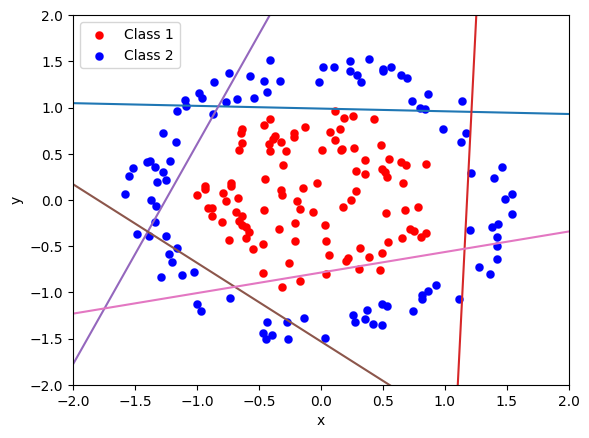

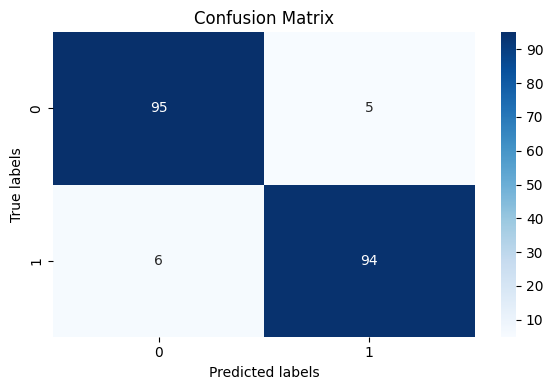

              precision    recall  f1-score   support

        -1.0       0.94      0.95      0.95       100
         1.0       0.95      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200



In [97]:
weights, biases, error_list = MRI(df0, df1, inputs,target,num_neurons_layer1 = 8 ,num_neurons_layer2 = 2,max_iter = 2000,learning_rate = 0.01,samples = inputs.shape[0])

sample: 200
Epoch 1 / 10
loss: 0.5174129353233831
W1: [ 0.00053928 -0.00034944]
b1: [-0.00040008]
W2: [0.00039341 0.00046223]
b2: [-0.00070011]
W3: [0.00022771 0.00014288]
b3: [-0.00040007]
W4: [0.00016899 0.00044785]
b4: [-0.00050011]
W5: [-0.00024536 -0.00018506]
b5: [-0.00029993]
W6: [0.00046693 0.00059907]
b6: [-0.00080015]
W7: [-0.00023814  0.00032618]
b7: [-0.00040003]
W8: [0.00046825 0.00036773]
b8: [-0.00070015]
Epoch 2 / 10
loss: 0.15
W1: [ 0.00045518 -0.00040223]
b1: [-0.00050008]
W2: [0.00039341 0.00046223]
b2: [-0.00070011]
W3: [0.00022771 0.00014288]
b3: [-0.00040007]
W4: [0.00016899 0.00044785]
b4: [-0.00050011]
W5: [-0.00023614 -0.00023482]
b5: [-0.00039996]
W6: [0.00046693 0.00059907]
b6: [-0.00080015]
W7: [-0.0002261   0.00027262]
b7: [-0.00050003]
W8: [0.00046825 0.00036773]
b8: [-0.00070015]
Epoch 3 / 10
loss: 0.18
W1: [ 0.00036473 -0.00040947]
b1: [-0.00060009]
W2: [0.00039341 0.00046223]
b2: [-0.00070011]
W3: [0.00022771 0.00014288]
b3: [-0.00040007]
W4: [0.0001689

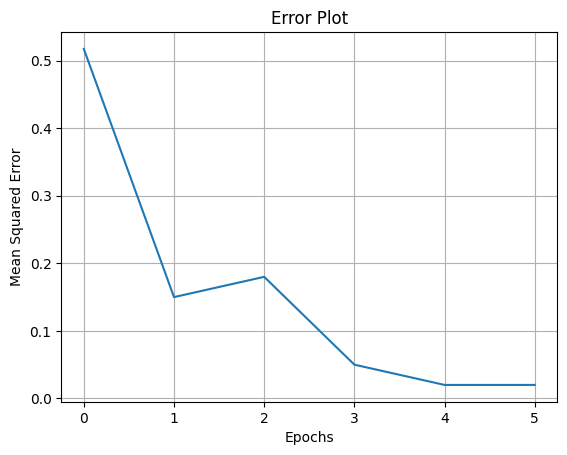

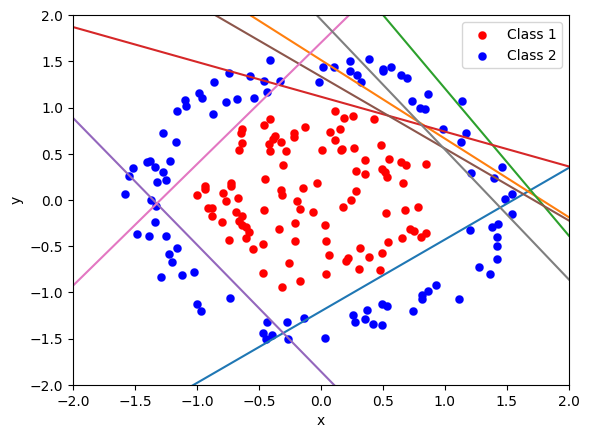

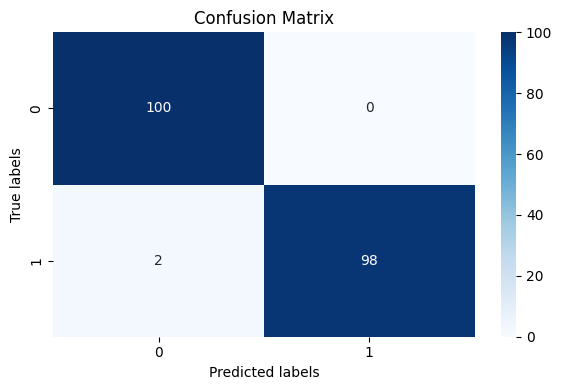

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       100
         1.0       1.00      0.98      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [98]:
weights, biases, error_list = MRI(df0, df1, inputs,target,num_neurons_layer1 = 8 ,num_neurons_layer2 = 2,max_iter = 2000,learning_rate = 0.0001,samples = inputs.shape[0])